In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class Grid:
    def __init__(self, nrows, ncols, pos_start, pos_goal, pos_obstacles, epsilon=0.1, alpha=0.1, 
                 num_episodes=1, learning_method="sarsa"):
        self.nrows = nrows
        self.ncols = ncols
        self.grid = np.zeros((nrows, ncols))
        self.pos_start = pos_start
        self.pos_goal = pos_goal
        self.pos_obstacles = pos_obstacles
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_episodes = num_episodes
        self.learning_method=learning_method
        
        self.UP = 0
        self.RIGHT = 1
        self.DOWN = 2
        self.LEFT = 3
        
        self.set_grid()
        self.Q = self.initialise_q_values()
        
        self.reward_with_episodes = []
        
        self.policy_unchanged_episodes = 0
    
    def set_grid(self):
        self.grid[self.pos_start] = 1
        self.grid[self.pos_goal] = 2
        self.grid[self.pos_obstacles[:, 0], self.pos_obstacles[:, 1]] = 3
        
    def initialise_q_values(self):
        Q = np.random.rand(self.nrows, self.ncols, 4)
        Q[self.pos_goal[0], self.pos_goal[1], :] = [0]*4
        
        for i in range(self.nrows):
            for j in range(self.ncols):
                available_actions = self.get_available_actions((i, j))
                for action in range(4):
                    if action not in available_actions:
                        Q[i][j][action] = -10**3
        
        return Q
        
    def get_available_actions(self, state):
        
        assert state[0] >=0 and state[0] < self.nrows, "Row index excedded"
            
        assert state[1] >=0 and state[1] < self.ncols, "Column index excedded"
        
        if state[0] == 0:
            if state[1] == 0:
                return [self.UP, self.RIGHT]
            elif state[1] == self.ncols-1:
                return [self.UP, self.LEFT]
            else:
                return [self.UP, self.RIGHT, self.LEFT]
        elif state[0] == self.nrows - 1:
            if state[1] == 0:
                return [self.RIGHT, self.DOWN]
            elif state[1] == self.ncols-1:
                return [self.DOWN, self.LEFT]
            else:
                return [self.RIGHT, self.DOWN, self.LEFT]    
        elif state[1] == 0:
            return [self.UP, self.RIGHT, self.DOWN]
        elif state[1] == self.ncols - 1:
            return [self.UP, self.DOWN, self.LEFT]
        else:
            return [self.UP, self.RIGHT, self.DOWN, self.LEFT]        
    
    def choose_action(self, state, epsilon):
        available_actions = self.get_available_actions(state)
        while True:
            actions = [0, 1, 2, 3]
            max_q_value_idx = np.argmax(self.Q[state])

            greedy_prob = (1.0-epsilon) + epsilon/len(actions)
            rem_prob = (1.0 - greedy_prob)/(len(actions) - 1)

            probs = [rem_prob]*len(actions)
            probs[max_q_value_idx] = greedy_prob
            chosen_action = np.random.choice(actions, p=probs)
            
            if chosen_action in available_actions:
                return chosen_action
    
    def move(self, state, action):
        new_state = None
        if action == 0:
            new_state = (state[0]+1, state[1])
        elif action == 1:
            new_state = (state[0], state[1]+1)
        elif action == 2:
            new_state = (state[0]-1, state[1])
        else:
            new_state = (state[0], state[1]-1)
            
        return new_state
    
    def get_reward(self, new_state):
        if self.grid[new_state] == 2:
            return 20
        elif self.grid[new_state] == 3:
            return -100
        else:
            return -1
        
    def step(self, start_state):
        print("Learning algorithm: ", self.learning_method)
        if self.learning_method== "sarsa":
            for i in range(self.num_episodes):

                state = start_state
                action = self.choose_action(state, self.epsilon)
                
                reward_for_episode = 0
                
                while state != self.pos_goal:
                    new_state = self.move(state, action)
                    reward = self.get_reward(new_state)
                    
                    reward_for_episode +=  reward

                    new_action = self.choose_action(new_state, self.epsilon)

                    old_q_val = self.Q[state][action]
                    updated_q_val = old_q_val + self.alpha*(reward + self.Q[new_state][new_action] - old_q_val)
                    self.Q[state][action] = updated_q_val

                    state = new_state
                    action = new_action
                    
                self.reward_with_episodes.append(reward_for_episode)
                
        elif self.learning_method == "q-learning":
            for i in range(self.num_episodes):
                state = start_state
                
                reward_for_episode = 0
                while state != self.pos_goal:
                    action = self.choose_action(state, self.epsilon)
                    new_state = self.move(state, action)
                    reward = self.get_reward(new_state)
                    
                    reward_for_episode +=  reward

                    new_action = np.argmax(self.Q[new_state])

                    old_q_val = self.Q[state][action]
                    updated_q_val = old_q_val + self.alpha*(reward + self.Q[new_state][new_action] - old_q_val)
                    self.Q[state][action] = updated_q_val

                    state = new_state
                    
                self.reward_with_episodes.append(reward_for_episode)
                                
        print("Learning done!")
        
    def get_policy(self):
        grid_plot = np.copy(self.grid)
        for i in range(self.nrows):
            for j in range(self.ncols):
                action = np.argmax(self.Q[i][j])
                grid_plot[i][j] = action
        return grid_plot
        
    def get_grid(self):
        return np.flip(self.get_policy(), axis=0)

In [7]:
def plot_policy(scale, final_grid):
    scale = 0.25
    fig, ax = plt.subplots(figsize=(21, 4))
    for r, row in enumerate(final_grid):
        for c, cell in enumerate(row):
            if cell == 0.0:
                dx, dy = 0, scale
            elif cell == 1.0:
                dx, dy = scale, 0.0
            elif cell == 2.0:
                dx, dy = 0, -scale
            else:
                dx, dy = -scale, 0.0

            plt.arrow(c, final_grid.shape[0]-1-r, dx, dy, head_width=0.1)
            
def plot_rewards(rewards):
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(1, len(rewards) + 1), rewards)
    plt.xlabel("Num epsiodes")
    plt.ylabel("Reward per episode")
            
            
def get_trained_policy(params, learning_method="sarsa"):
    nrows = params["nrows"]
    ncols = params["ncols"]
    pos_start = params["pos_start"]
    pos_goal = params["pos_goal"]
    pos_obstacles = params["pos_obstacles"]
    epsilon = params["epsilon"]
    alpha = params["alpha"]
    num_episodes = params["num_episodes"]
    
    
    if learning_method == "sarsa":
        sarsa_grid = Grid(nrows, ncols, pos_start, pos_goal, pos_obstacles, epsilon=epsilon, alpha=alpha, 
                num_episodes=num_episodes, learning_method=learning_method)
        sarsa_grid.step(pos_start)


        final_sarsa_grid = sarsa_grid.get_grid()
        
        sarsa_rewards = sarsa_grid.reward_with_episodes
        
        return final_sarsa_grid, sarsa_rewards
    else:
        q_learning_grid = Grid(nrows, ncols, pos_start, pos_goal, pos_obstacles, epsilon=epsilon, alpha=alpha, 
            num_episodes=num_episodes, learning_method=learning_method)
        q_learning_grid.step(pos_start)
        
        final_q_learning_grid = q_learning_grid.get_grid()
        
        q_learning_rewards = q_learning_grid.reward_with_episodes
        
        return final_q_learning_grid, q_learning_rewards
        

In [8]:
params = {
    "nrows": 4,
    "ncols": 21,
    "pos_start": (0, 0),
    "pos_goal": (0, 20),
    "epsilon": 0.1,
    "alpha": 0.3,
    "num_episodes": 10**4,
}

## 2.1 SARSA vs Q-learning

In [10]:
epsilon = 0.6
scale  = 0.25
params["pos_obstacles"] = np.array([(0, i) for i in range(1, params["ncols"]-1)])

Learning algorithm:  sarsa
Learning done!


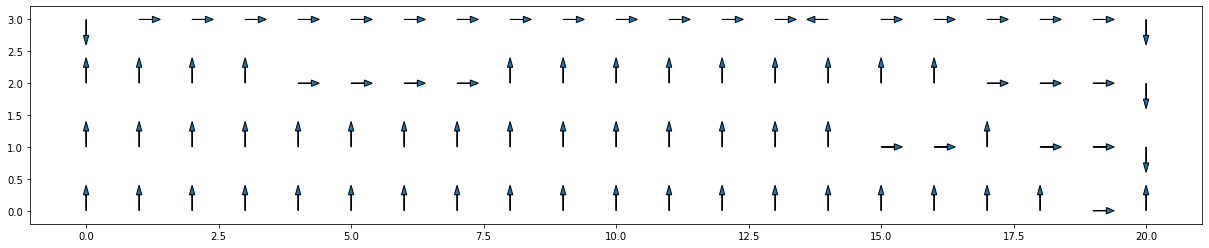

In [11]:
params["epsilon"] = epsilon
learning_method="sarsa"

final_sarsa_grid, sarsa_rewards = get_trained_policy(params, learning_method)

plot_policy(scale, final_sarsa_grid)
plt.savefig("./images/cliff_walk_sarsa_policy_{}_new.jpg".format(params["epsilon"]), bbox_inches="tight")

Learning algorithm:  q-learning
Learning done!


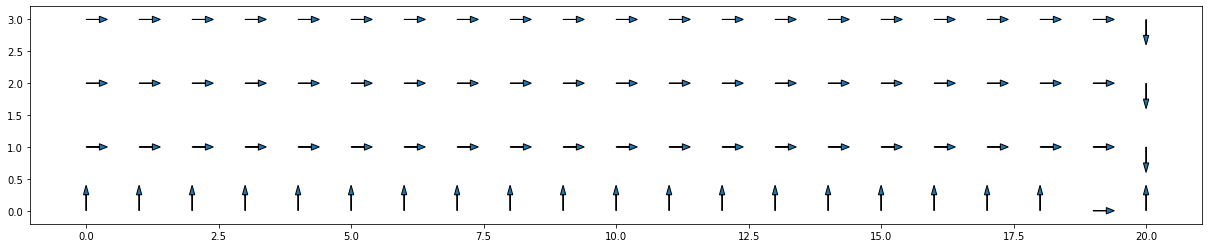

In [12]:
learning_method="q-learning"

final_q_learning_grid, q_learning_rewards = get_trained_policy(params, learning_method)

plot_policy(scale, final_q_learning_grid)
plt.savefig("./images/cliff_walk_q_learning_policy_{}.jpg".format(epsilon), bbox_inches="tight")

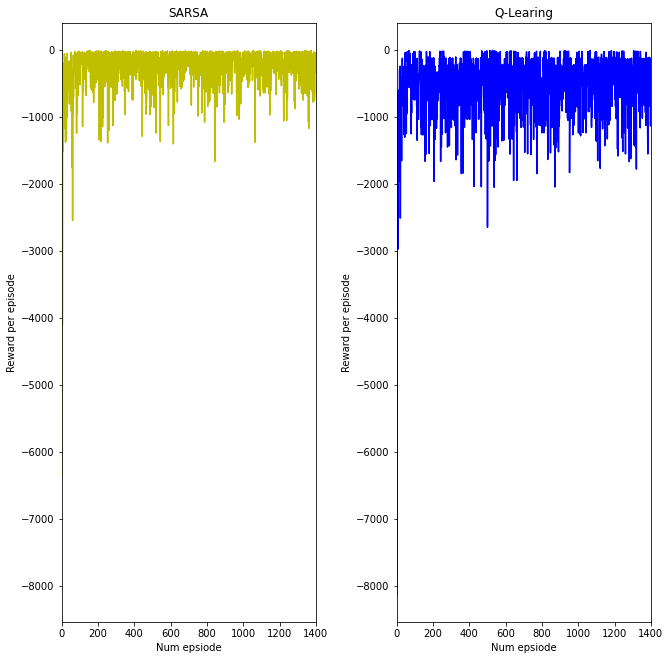

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

fig.tight_layout(pad=5.0)

ax[0].plot(np.arange(1, len(sarsa_rewards) + 1), sarsa_rewards, c='y', label = "SARSA")
ax[0].set_xlabel("Num epsiode")
ax[0].set_ylabel("Reward per episode")
ax[0].set_title("SARSA")
ax[0].set_xlim(0, 1400)

ax[1] = plt.subplot(1, 2, 2, sharey=ax[0], sharex=ax[0])
ax[1].plot(np.arange(1, len(q_learning_rewards) + 1), q_learning_rewards, c='b', label="Q-learning")
ax[1].set_xlabel("Num epsiode")
ax[1].set_ylabel("Reward per episode")
ax[1].set_title("Q-Learing")
ax[1].set_xlim(0, 1400)

plt.savefig("./images/cliff_sarsa_and_q_learning_reward_{}.jpg".format(epsilon), bbox_inches="tight")

## 2.2 Varying Epsilon

In [7]:
list_epsilon  = [0.1, 0.3, 0.6, 0.9]
params["pos_obstacles"] = np.array([(0, i) for i in range(1, params["ncols"]-1)])
scale=0.25

Learning algorithm:  sarsa
Learning done!
Learning algorithm:  q-learning
Learning done!
**********
Learning algorithm:  sarsa
Learning done!
Learning algorithm:  q-learning
Learning done!
**********
Learning algorithm:  sarsa
Learning done!
Learning algorithm:  q-learning
Learning done!
**********
Learning algorithm:  sarsa
Learning done!
Learning algorithm:  q-learning
Learning done!
**********


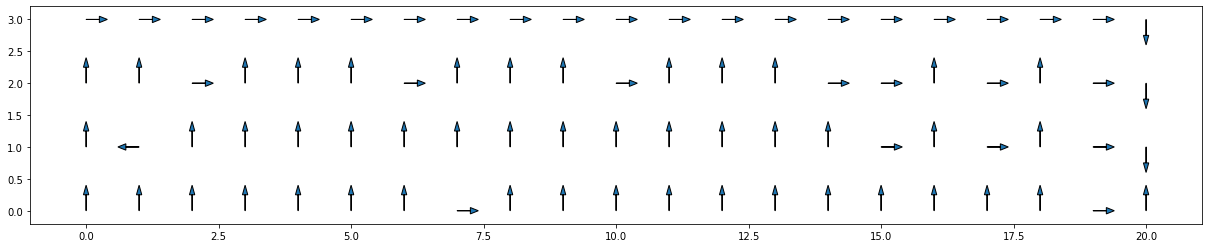

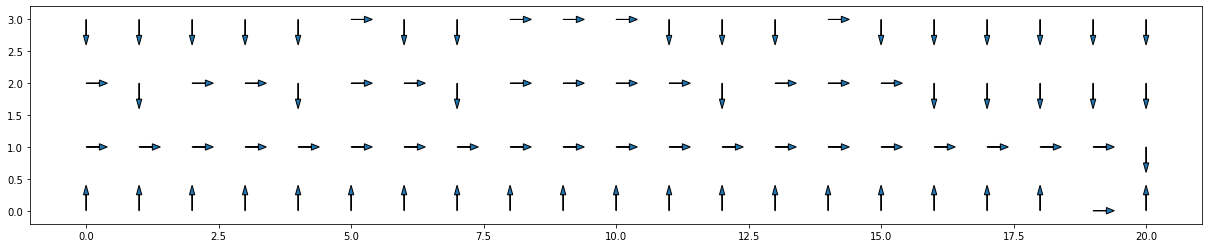

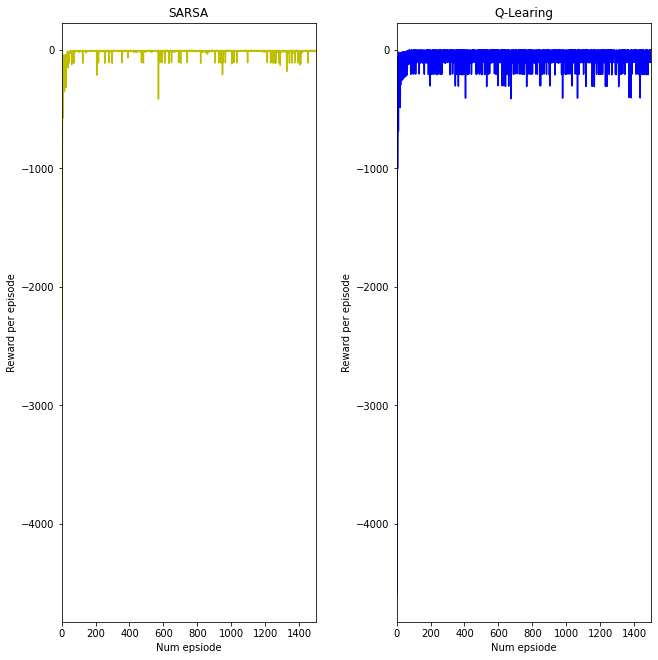

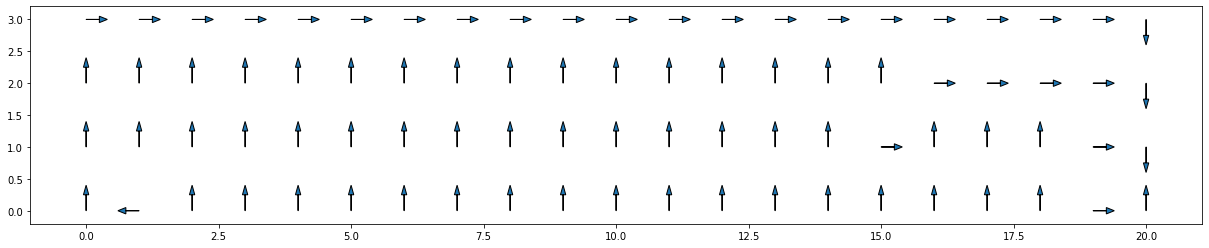

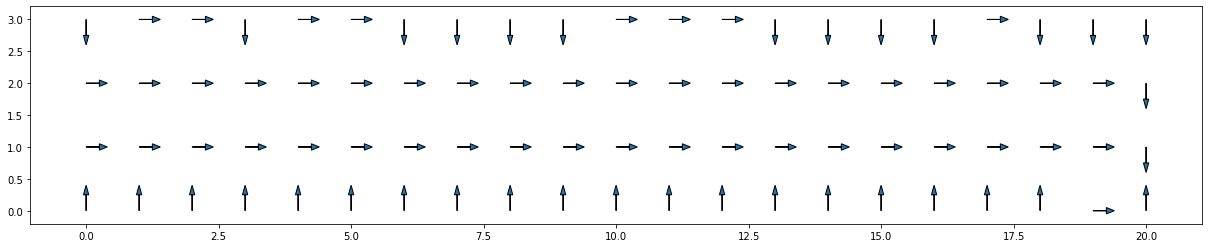

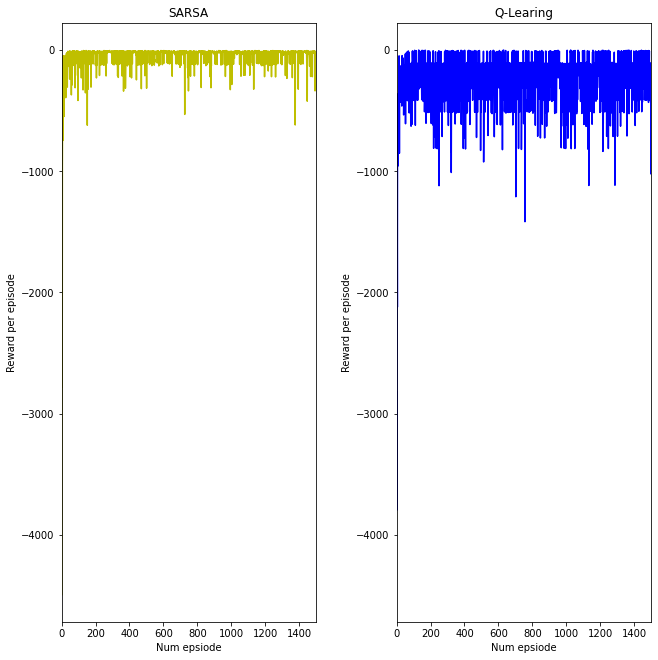

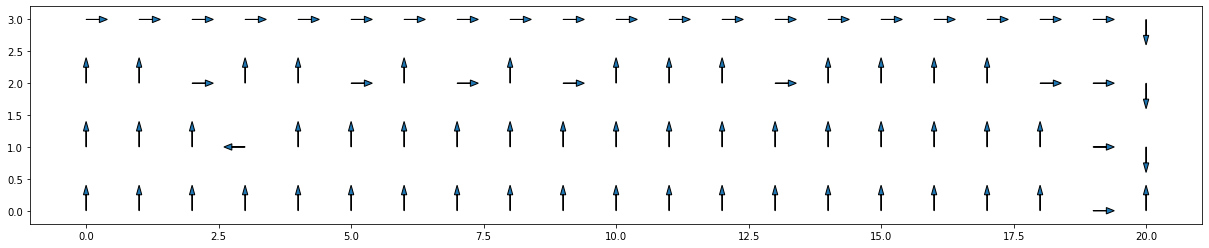

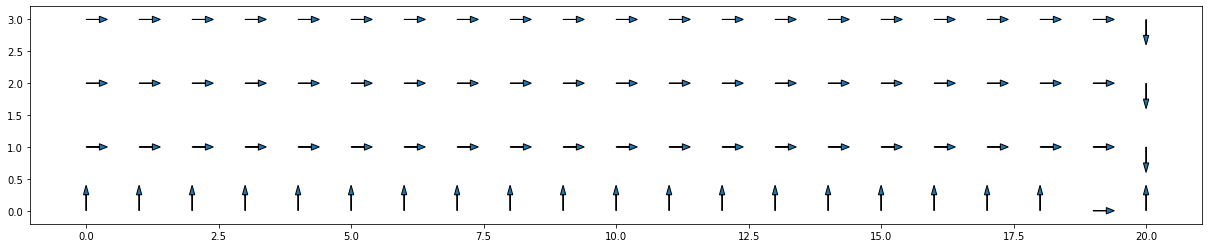

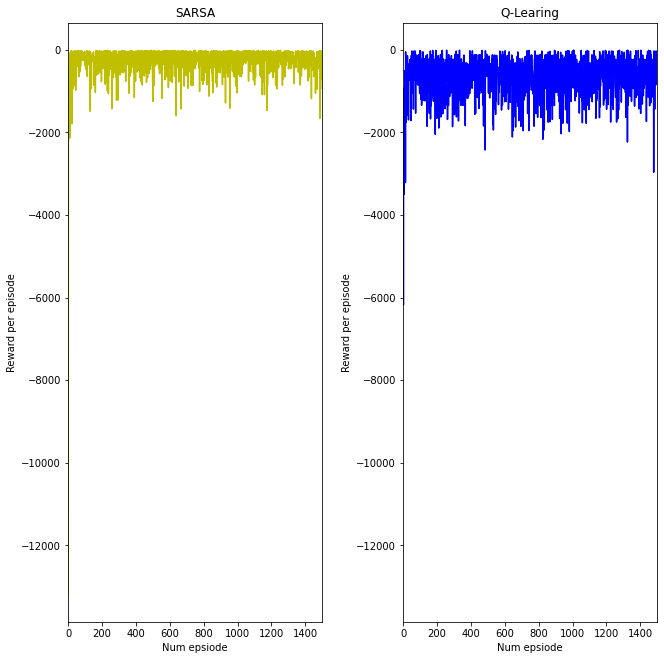

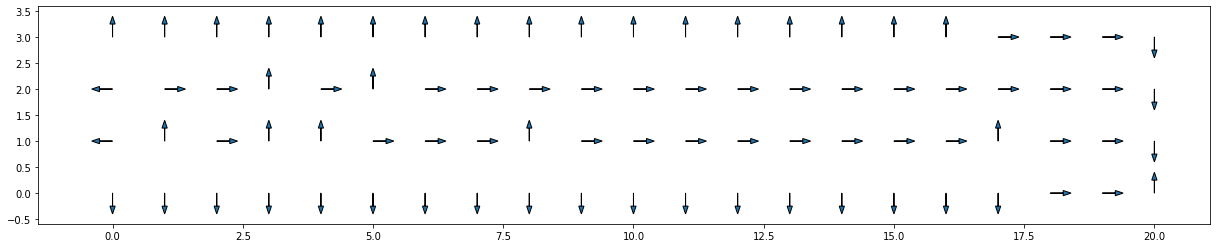

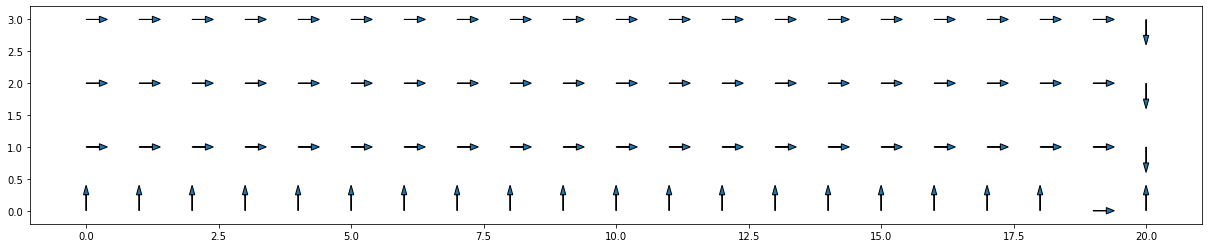

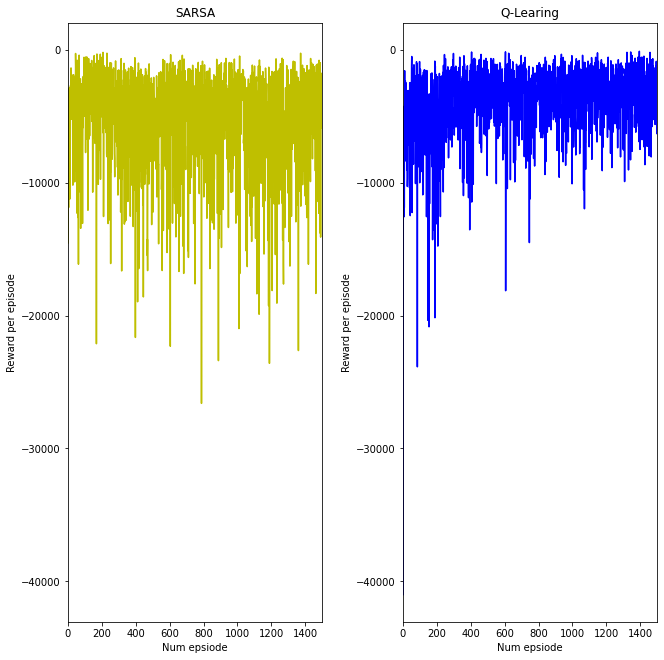

In [8]:
for epsilon in list_epsilon:
    params["epsilon"] = epsilon

    final_sarsa_grid, sarsa_rewards = get_trained_policy(params, learning_method="sarsa")

    plot_policy(scale, final_sarsa_grid)
    plt.savefig("./images/cliff_walk_sarsa_policy_{}.jpg".format(epsilon), bbox_inches="tight")

    final_q_learning_grid, q_learning_rewards = get_trained_policy(params, learning_method="q-learning")

    plot_policy(scale, final_q_learning_grid)
    plt.savefig("./images/cliff_walk_q_learning_policy_{}.jpg".format(epsilon), bbox_inches="tight")
    
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    fig.tight_layout(pad=5.0)

    ax[0].plot(np.arange(1, len(sarsa_rewards) + 1), sarsa_rewards, c='y', label = "SARSA")
    ax[0].set_xlabel("Num epsiode")
    ax[0].set_ylabel("Reward per episode")
    ax[0].set_title("SARSA")
    ax[0].set_xlim(0, 1500)

    ax[1] = plt.subplot(1, 2, 2, sharey=ax[0], sharex=ax[0])
    ax[1].plot(np.arange(1, len(q_learning_rewards) + 1), q_learning_rewards, c='b', label="Q-learning")
    ax[1].set_xlabel("Num epsiode")
    ax[1].set_ylabel("Reward per episode")
    ax[1].set_title("Q-Learing")
    ax[1].set_xlim(0, 1500)
    plt.savefig("./images/cliff_sarsa_and_q_learning_reward_{}.jpg".format(epsilon), bbox_inches="tight")
    
    print("*"*10)

## 2.3 Snake Pit

In [9]:
epsilon = 0.1
scale  = 0.25

obstacles = np.array([(0, i) for i in range(1, params["ncols"]-1)])
obstacles = np.vstack([obstacles, [3, 10]])

params["pos_obstacles"] = obstacles
params["num_episodes"] = 10**4
params["epsilon"] = epsilon

Learning algorithm:  sarsa
Learning done!


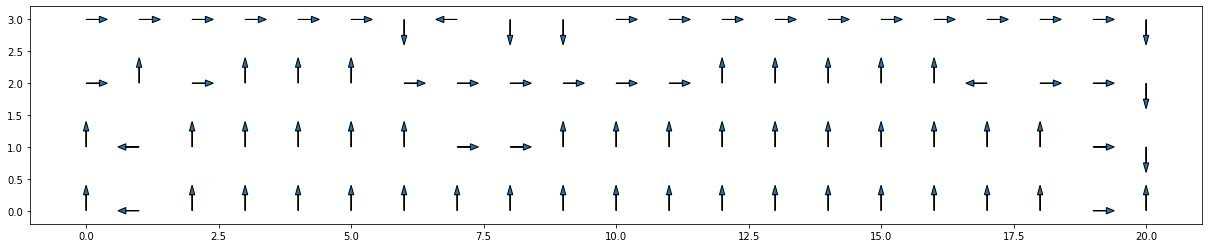

In [10]:
learning_method="sarsa"

final_sarsa_grid, sarsa_rewards = get_trained_policy(params, learning_method)

plot_policy(scale, final_sarsa_grid)
plt.savefig("./images/cliff_walk_sarsa_policy_snakepit_{}.jpg".format(params["epsilon"]), bbox_inches="tight")

Learning algorithm:  q-learning
Learning done!


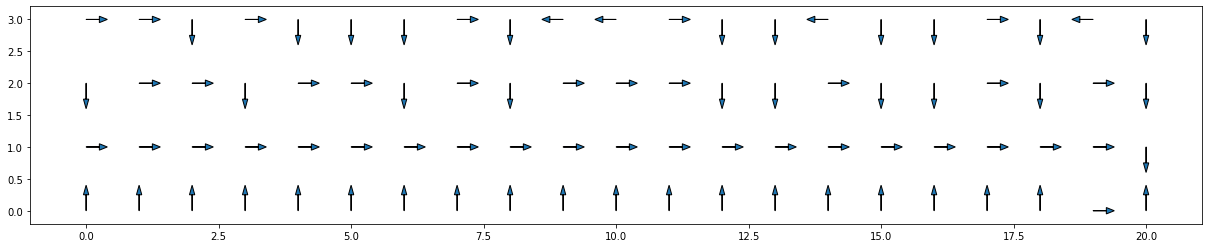

In [11]:
learning_method="q-learning"

final_q_learning_grid, q_learning_rewards = get_trained_policy(params, learning_method)

plot_policy(scale, final_q_learning_grid)
plt.savefig("./images/cliff_walk_q_learning_policy_snakepit_{}.jpg".format(params["epsilon"]), bbox_inches="tight")

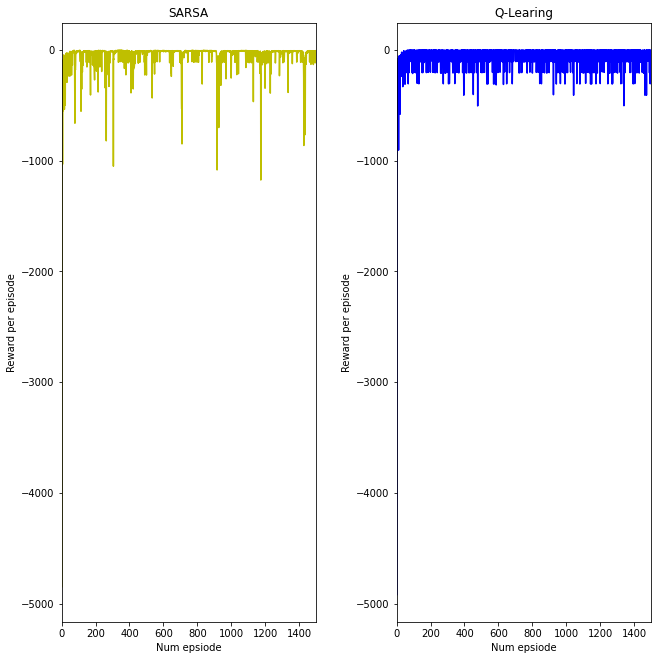

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

fig.tight_layout(pad=5.0)

ax[0].plot(np.arange(1, len(sarsa_rewards) + 1), sarsa_rewards, c='y', label = "SARSA")
ax[0].set_xlabel("Num epsiode")
ax[0].set_ylabel("Reward per episode")
ax[0].set_title("SARSA")
ax[0].set_xlim(0, 1500)

ax[1] = plt.subplot(1, 2, 2, sharey=ax[0], sharex=ax[0])
ax[1].plot(np.arange(1, len(q_learning_rewards) + 1), q_learning_rewards, c='b', label="Q-learning")
ax[1].set_xlabel("Num epsiode")
ax[1].set_ylabel("Reward per episode")
ax[1].set_title("Q-Learing")
ax[1].set_xlim(0, 1500)


plt.savefig("./images/cliff_sarsa_and_q_learning__snakepit_reward_{}.jpg".format(params["epsilon"]), bbox_inches="tight")